<a href="https://colab.research.google.com/github/LeuroPrince/Literature-Reproduction-for-WenLab/blob/main/Reproduction_of_figure3D_for_WenLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
Fig3D_file_path= '/content/drive/My Drive/WenLab/Figure 3-source data for Figure 3D.xlsx'
df_Fig3D = pd.read_excel(Fig3D_file_path,sheet_name=None,header=0)
df_3D_sum = pd.read_excel(Fig3D_file_path,sheet_name='Summary',header=4)

df_3D_sum.columns = df_3D_sum.columns.str.strip()
# df_Fig3D['WEN0851_Pnpr-9  Chrimson'].head()
print(" 清理后的实际列名列表 ")
actual_column_names = df_3D_sum.columns.tolist()
print(actual_column_names)
print("--")
df_Fig3D.keys()





 清理后的实际列名列表 
['worm name', 'n_all', 'n_turn', 'turn rate', 'p-value', 'Unnamed: 5', 'lower\xa0confidence\xa0limit', 'upper\xa0confidence\xa0limit', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12']
--


dict_keys(['Summary', 'WEN0851_Pnpr-9  Chrimson', 'WEN0119_inx-1;Pnpr-9  Chrimson', 'inx-1 rescue'])

In [15]:

try:
    control_data = df_3D_sum[df_3D_sum['worm name'].str.contains("WEN0851", na=False)].iloc[0]
    mutant_data = df_3D_sum[df_3D_sum['worm name'].str.contains("inx-1;AIB::Chrimson", na=False)].iloc[0]
    rescue_data = df_3D_sum[df_3D_sum['worm name'].str.contains("inx-1 rescue", na=False)].iloc[0]

    # 提取概率 (条形图高度)
    probabilities = [control_data['turn rate'], mutant_data['turn rate'], rescue_data['turn rate']]
    lower_limit_col_name = 'lower\xa0confidence\xa0limit'
    upper_limit_col_name = 'upper\xa0confidence\xa0limit'

    lower_limits = [control_data[lower_limit_col_name], mutant_data[lower_limit_col_name], rescue_data[lower_limit_col_name]]
    upper_limits = [control_data[upper_limit_col_name], mutant_data[upper_limit_col_name], rescue_data[upper_limit_col_name]]

    # 计算误差棒长度 (确保为正数)
    lower_errors = np.abs(np.array(probabilities) - np.array(lower_limits))
    upper_errors = np.abs(np.array(upper_limits) - np.array(probabilities))
    # plt.bar 的 yerr 参数需要 [下误差, 上误差]
    errors = [lower_errors, upper_errors]

    # 准备标签
    labels = ['Pnpr-9::Chrimson\n(Control)', 'inx-1;Pnpr-9::Chrimson\n(Mutant)', 'inx-1 rescue\n(Rescue)']
    print("  Probabilities:", probabilities)
    print("  Errors (lower, upper):", errors)
except (KeyError, IndexError) as e:
    print(f"步骤 1/2: 数据提取失败！请检查 Summary Sheet 的内容和列名是否正确。错误: {e}")
    # 如果提取失败，停止执行
    raise e

  Probabilities: [np.float64(0.9811320754716981), np.float64(0.6024096385542169), np.float64(0.9705882352941176)]
  Errors (lower, upper): [array([0.05712549, 0.11338379, 0.07282925]), array([0.0185114 , 0.10585353, 0.0258298 ])]


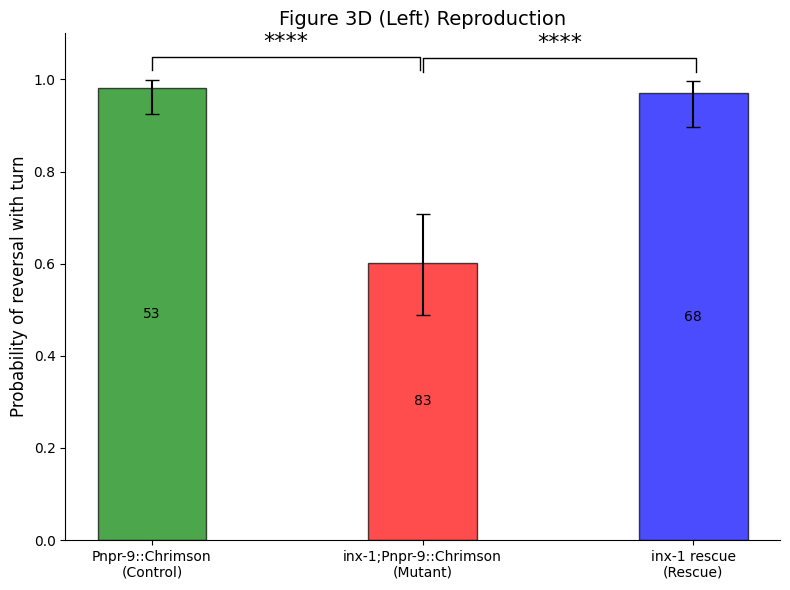

步骤 2/2: 条形图绘制成功！


In [16]:
##绘制图形
#  2. 绘制条形图
plt.figure(figsize=(8, 6))

# 设置条形图颜色 (对应 Fig 3D: 绿, 红, 蓝)
colors = ['green', 'red', 'blue']
# 条形图的 X 轴位置
x_pos = np.arange(len(labels))

# 绘制条形图，并传入计算好的误差
plt.bar(x_pos, probabilities, yerr=errors, capsize=5, color=colors, alpha=0.7, edgecolor='black',width=[0.4,0.4,0.4])

# 添加文本标签 (在条形图内部显示 n_turn / n_all)
# 从之前提取的数据中获取 n_turn 和 n_all
n_turn = [control_data['n_turn'], mutant_data['n_turn'], rescue_data['n_turn']]
n_all = [control_data['n_all'], mutant_data['n_all'], rescue_data['n_all']]

for i in range(len(labels)):
    # 将数字转为整数再格式化
    plt.text(x_pos[i], probabilities[i] * 0.5, f"{int(n_all[i])}",
             ha='center', va='center', color='black', fontsize=10)

def add_significance_bracket(x1, x2, y_start, text):
    """辅助函数，用于绘制显著性标记线和文本"""
    line_y = y_start + 0.03 # 标记线的高度，比y_start稍高
    text_y = line_y + 0.01  # 星号文本的高度
    # 绘制水平线
    plt.plot([x1, x1, x2, x2], [y_start, line_y, line_y, y_start], lw=1.0, c='black')
    # 添加星号文本
    plt.text((x1 + x2) * 0.5, text_y, text, ha='center', va='bottom', fontsize=16)

# a) 比较 Control (x=0) vs Mutant (x=1)
p_val_mutant = mutant_data.get('p-value', 1.0) # 使用 .get 防止 p-value 列不存在时报错
if pd.notna(p_val_mutant) and p_val_mutant < 0.0001:
    # 找到这两根柱子误差棒的最高点
    y_max = max(upper_limits[0], upper_limits[1])
    add_significance_bracket(x_pos[0], x_pos[1]-0.01, y_max + 0.02, '****')

# b) 比较 Mutant (x=1) vs Rescue (x=2)
p_val_rescue = rescue_data.get('p-value', 1.0)
if pd.notna(p_val_rescue) and p_val_rescue < 0.0001:
    # 找到这两根柱子误差棒的最高点
    y_max = max(upper_limits[1], upper_limits[2])
    # 注意：为了避免标记线重叠，第二条线需要画得更高一点
    add_significance_bracket(x_pos[1], x_pos[2]+0.01, y_max + 0.02, '****')

#  美化图表
plt.ylabel('Probability of reversal with turn', fontsize=12)
plt.xticks(x_pos, labels, fontsize=10, rotation=0) # X 轴标签
plt.ylim(0, 1.1) # Y 轴范围，留出上方空间给星号
plt.title('Figure 3D (Left) Reproduction', fontsize=14)
plt.grid(False) # 关闭背景网格
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.tight_layout() # 调整布局防止标签重叠
plt.show()
print("步骤 2/2: 条形图绘制成功！")

In [27]:
# df_control = df_Fig3D['WEN0851_Pnpr-9  Chrimson']
# df_mutant = df_Fig3D['WEN0119_inx-1;Pnpr-9  Chrimson']
# df_rescue = df_Fig3D['inx-1 rescue']
df_control = pd.read_excel(Fig3D_file_path,sheet_name="WEN0851_Pnpr-9  Chrimson",header=2)
df_mutant = df_Fig3D['WEN0119_inx-1;Pnpr-9  Chrimson']
df_rescue = df_Fig3D['inx-1 rescue']
df_rescue.head()


,worm name,reversal duration,turn
0,20180515w1,3.043,1
1,NaN,5.129,1
2,NaN,1.661,1
3,NaN,4.360,1
4,NaN,5.555,1


成功加载 Figure 3D 的三组原始数据。

--- Starting calculation of Figure 3D (Right) experimental data points ---
Processing: Control...
Processing: Mutant...
Processing: Rescue...
--- All experimental data points calculated. ---

Starting plotting and fitting...
Successfully fitted: Control
Successfully fitted: Mutant
Successfully fitted: Rescue


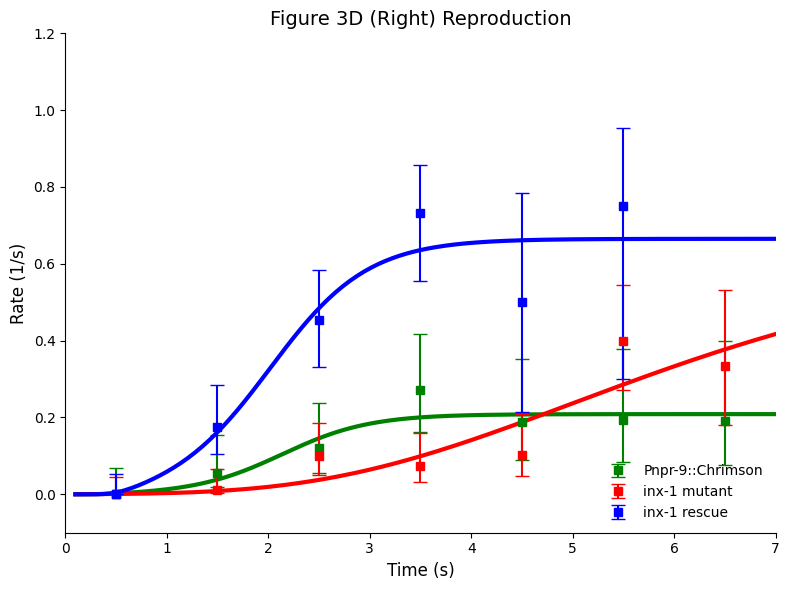


Figure 3D (Right) plotting complete!


In [31]:
#此处的代码与Figure4A的代码一样，详细注释可以去4A那里找到
DATA_FILES_3D = {
        'Control': df_control,
        'Mutant':  df_mutant,
        'Rescue':  df_rescue
    }
print("成功加载 Figure 3D 的三组原始数据。")

from scipy.special import erfi # 导入拟合函数需要的 erfi
from scipy.optimize import curve_fit # Import curve_fit
from statsmodels.stats.proportion import proportion_confint

def r2_fit_function_v2(t, k1, k2, k3, k4):
    """
    论文中使用的拟合函数: r2(t) = k1 / erfi( k2 + k3 * exp(-t / k4) )
    """
    argument = k2 + k3 * np.exp(-t / k4)
    # 加上一个极小值(epsilon)来防止分母为零，这在数值计算中很常见
    denominator = erfi(argument) + 1e-9
    return k1 / denominator



BEHAVIOR_COL = 'turn'

# Time bin settings
TIME_BINS = np.arange(0, 8, 1)  #
STATE_WE_CARE_ABOUT = 1


experimental_data_3D = {}

print("\n--- Starting calculation of Figure 3D (Right) experimental data points ---")

for group_name, df in DATA_FILES_3D.items():
    print(f"Processing: {group_name}...")

    if group_name == 'Mutant':
        TIME_COL = 'reversal length' # mutant组的列名又不一样
    else:
        TIME_COL = 'reversal duration'


    df_proc = df.copy()

    df_proc[TIME_COL] = pd.to_numeric(df_proc[TIME_COL], errors='coerce')
    df_proc[BEHAVIOR_COL] = pd.to_numeric(df_proc[BEHAVIOR_COL], errors='coerce')
    df_proc = df_proc.dropna(subset=[TIME_COL, BEHAVIOR_COL])


    x_coords, rates, ci_low, ci_high = [], [], [], []

    # Calculate conversion rate by time bin
    for i in range(len(TIME_BINS) - 1):
        bin_start, bin_end = TIME_BINS[i], TIME_BINS[i+1]


        survivors = df_proc[df_proc[TIME_COL] >= bin_start]
        current_S_total = len(survivors)

        events_in_bin = survivors[
            (survivors[TIME_COL] < bin_end) &
            (survivors[BEHAVIOR_COL] == STATE_WE_CARE_ABOUT)
        ]
        current_n_events = len(events_in_bin)

        # X-axis coordinate (center point of the bin)
        x_coords.append((bin_start + bin_end) / 2)

        if current_S_total > 0:
            rate = current_n_events / current_S_total
            low, high =proportion_confint(current_n_events, current_S_total, method='wilson')
            rates.append(rate); ci_low.append(low); ci_high.append(high)
        else:
            rates.append(np.nan); ci_low.append(np.nan); ci_high.append(np.nan)
    experimental_data_3D[group_name] = {
        'x': np.array(x_coords),
        'y': np.array(rates),
        'ci_low': np.array(ci_low),
        'ci_high': np.array(ci_high),
    }

print("--- All experimental data points calculated. ---")

print("\nStarting plotting and fitting...")

fig, ax = plt.subplots(figsize=(8, 6))

LABELS_3D = {
    'Control': 'Pnpr-9::Chrimson',
    'Mutant':  'inx-1 mutant',
    'Rescue':  'inx-1 rescue'
}
COLORS_3D = {
    'Control': 'green',
    'Mutant':  'red',
    'Rescue':  'blue'
}

t_smooth = np.linspace(0.1, 7, 200)


initial_guesses = [1.0, 0.1, 0.5, 1.0]

for group_name, data in experimental_data_3D.items():
    # A: Plot experimental data points and error bars
    y_error = [data['y'] - data['ci_low'], data['ci_high'] - data['y']]
    ax.errorbar(data['x'], data['y'], yerr=y_error,
                fmt='s', capsize=5,
                color=COLORS_3D[group_name],
                label=f"{LABELS_3D[group_name]}")

    # B: Prepare fitting data (curve_fit cannot handle NaN)
    valid_indices = ~np.isnan(data['y'])
    x_fit = data['x'][valid_indices]
    y_fit = data['y'][valid_indices]

    # C: Perform fitting
    if len(x_fit) > 1: # Need at least 2 points to fit
        try:
            # Increased maxfev and added method='lm' for potentially better convergence
            params, _ = curve_fit(r2_fit_function_v2, x_fit, y_fit, p0=initial_guesses, maxfev=100000, method='lm')
            y_smooth = r2_fit_function_v2(t_smooth, *params)
            ax.plot(t_smooth, y_smooth, color=COLORS_3D[group_name], lw=3)
            print(f"Successfully fitted: {group_name}")
        except RuntimeError as e:
            print(f"*** Warning: Could not find suitable fitting parameters for {group_name}. Error: {e}. Only data points will be shown.")


ax.set_title('Figure 3D (Right) Reproduction', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Rate (1/s)', fontsize=12)
ax.set_xlim(0, 7)
ax.set_ylim(-0.1, 1.2) # Y-axis range starts from -0.1 to better display bottom data points
ax.set_xticks(np.arange(0, 8, 1))
ax.legend(loc='lower right', frameon=False) # Legend position adjusted to lower right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

print("\nFigure 3D (Right) plotting complete!")